In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing

from pandas import Series

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-car-price-prediction/sample_submission.csv
/kaggle/input/sf-dst-car-price-prediction/test.csv
/kaggle/input/autotrain/auto_train.csv


In [3]:
# parsing libraries
from bs4 import BeautifulSoup
import requests
import time

In [4]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Feature Engineering
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, mutual_info_regression

In [5]:
#ml

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold
from tqdm import tqdm
import warnings

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
import math

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.base import clone

In [6]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
RANDOM_SEED = 14

In [7]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
pd.set_option('display.width', 1000)

## 1. Просмотр данных

In [8]:
test = pd.read_csv('../input/sf-dst-car-price-prediction/test.csv')
test.sample(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
29468,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x5_m/110046...,белый,NaN,ПРОСЬБА САЛОНАМ И ПЕРЕКУПАМ НЕ БЕСПОКОИТЬ!!! О...,4.4 LTR,555 N12,NaN,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,140000,2009,"{""code"":""X5_M"",""name"":""X5 M"",""ru_name"":""Х5 М"",...",X5_M,4.4 AT (555 л.с.) 4WD,5,1603561001,RUB,2011,1100461662,"{""id"":""20496165"",""displacement"":4395,""engine_t...",ALLROAD_5_DOORS AUTOMATIC 4.4,автоматическая,EUROPEAN,1 владелец,8 лет и 4 месяца,Оригинал,полный,Левый,Не требует ремонта,Растаможен
20788,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/used/sale/toyota/land_cru...,зелёный,NaN,"Авто по ПТС 1997​ год ,​\n\nПТС -ОРИГИНАЛ\n\nЯ...",3.0 LTR,125 N12,NaN,дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,405852,1996,"{""code"":""LAND_CRUISER_PRADO"",""name"":""Land Crui...",LAND_CRUISER_PRADO,3.0d AT (125 л.с.) 4WD,5,1603293086,RUB,1997,1100987440,"{""id"":""21341418"",""displacement"":2982,""engine_t...",ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,JAPANESE,3 или более,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

Из 32 столбцов:
- 3 числовых: mileage, numberOfDoors, sell_id
- 3 временных: modelDate, productionDate,parsing_unixtime
- 15 категориальных: bodyType, brand, color, fuelType, model_name, priceCurrency, vehicleTransmission, vendor, Владельцы, Владение, ПТС, Привод, Руль, Состояние, Таможня

Проверим типичные значения показателей тестового датасета для построения тренировочного.

In [10]:
for col in test.columns:
    if col not in ['car_url', 'complectation_dict', 'equipment_dict', 
                   'description', 'image', 'model_info', 
                   'parsing_unixtime', 'sell_id', 'super_gen']:
        print(f'name of column: {col}', '\n', test[col].value_counts()[:10], '\n')

name of column: bodyType 
 седан                   13147
внедорожник 5 дв.       12228
лифтбек                  2232
хэтчбек 5 дв.            2124
универсал 5 дв.          1276
минивэн                   995
купе                      824
компактвэн                489
хэтчбек 3 дв.             485
пикап двойная кабина      280
Name: bodyType, dtype: int64 

name of column: brand 
 BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
Name: brand, dtype: int64 

name of column: color 
 чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
Name: color, dtype: int64 

name of column: engineDisplacement 
 2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2477
2.4 LTR    1745
3.5 L

## 2. Парсинг сайта auto.ru

Для подготовки к парсингу создадим словарь brand_dict, где ключи - марки автомобилей, а значения - их кол-ва в test.

In [11]:
brands = test.brand.value_counts()
brand_dict = {brands.index[i]: brands[i] for i in range(len(brands))}
brand_dict

{'BMW': 4473,
 'VOLKSWAGEN': 4404,
 'NISSAN': 4393,
 'MERCEDES': 4180,
 'TOYOTA': 3913,
 'AUDI': 3421,
 'MITSUBISHI': 2843,
 'SKODA': 2741,
 'VOLVO': 1463,
 'HONDA': 1150,
 'INFINITI': 871,
 'LEXUS': 834}

In [12]:
"""
auto_makes = test.brand.value_counts().index
cars_final = []  # список из списков параметров для каждого авто
url = 'https://auto.ru/moskva/cars/{}/used/?output_type=list&page={}'

for make in auto_makes:  # цикл по всем маркам, представленным в test
    
    for i in range(1, 1201):  # цикл по страницам сайта auto.ru
        print(make, ', page No: ', i)
        
        response = requests.get(url.format(make, i))
        if response.status_code != 200:
            raise BaseException("response code: " + str(response.status_code))
        response.encoding = 'utf-8'
        soup = BeautifulSoup(response.text, 'html.parser')
        page = soup.find_all('div', class_='ListingItem-module__container') # отбираем все блоки объявлений

        for k in range(len(page)):     # цикл по каждому объявлению на текущей странице
            auto_content = page[k].find_all('meta')
            auto_info_list = []
            
            for p in range(len(auto_content)):   # цикл по параметрам k-го объявления
                auto_info_list.append(str(auto_content[p])[15:].split('"')[0])

            pos_out = [4, 11, 12, 14, 15, 19]   # номера лишних параметров k-го объявления
            auto_info = []
            
            for n in range(len(auto_info_list)):   # цикл по списку параметров для удаления лишних
                if n not in pos_out:
                    auto_info.append(auto_info_list[n]) #.replace('\xa0', ' '))

            # Считываем пробег(он расположен отдельно от других данных)
            mileage = page[k].find('div', class_='ListingItem-module__kmAge')
            km = str(mileage)[39:].split('<')[0][:-3].replace('\xa0', '')
            auto_info.append(km)    # добавляем пробег
                        
            cars_final.append(auto_info)  # добавляем список пар-ров автомобиля в список списков

auto_pars = pd.DataFrame(cars_final)
auto_pars.head(3)
"""

'\nauto_makes = test.brand.value_counts().index\ncars_final = []  # список из списков параметров для каждого авто\nurl = \'https://auto.ru/moskva/cars/{}/used/?output_type=list&page={}\'\n\nfor make in auto_makes:  # цикл по всем маркам, представленным в test\n    \n    for i in range(1, 1201):  # цикл по страницам сайта auto.ru\n        print(make, \', page No: \', i)\n        \n        response = requests.get(url.format(make, i))\n        if response.status_code != 200:\n            raise BaseException("response code: " + str(response.status_code))\n        response.encoding = \'utf-8\'\n        soup = BeautifulSoup(response.text, \'html.parser\')\n        page = soup.find_all(\'div\', class_=\'ListingItem-module__container\') # отбираем все блоки объявлений\n\n        for k in range(len(page)):     # цикл по каждому объявлению на текущей странице\n            auto_content = page[k].find_all(\'meta\')\n            auto_info_list = []\n            \n            for p in range(len(auto

In [13]:
"""
auto_parsing = pd.DataFrame(cars_final, columns=['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 
                                               'model_name', 'numberOfDoors', 'productionDate', 
                                               'vehicleConfiguration', 'vehicleTransmission', 'price', 
                                               'name', 'engineDisplacement', 'enginePower', 'mileage'])
display(auto_parsing.head(2))
auto_parsing['brand'].value_counts()
"""

"\nauto_parsing = pd.DataFrame(cars_final, columns=['bodyType', 'brand', 'color', 'fuelType', 'modelDate', \n                                               'model_name', 'numberOfDoors', 'productionDate', \n                                               'vehicleConfiguration', 'vehicleTransmission', 'price', \n                                               'name', 'engineDisplacement', 'enginePower', 'mileage'])\ndisplay(auto_parsing.head(2))\nauto_parsing['brand'].value_counts()\n"

In [14]:
train = pd.read_csv('../input/autotrain/auto_train.csv')
display(train.sample(2))
train.shape

,bodyType,brand,color,fuelType,modelDate,model_name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,price,name,engineDisplacement,enginePower,mileage
224199,внедорожник 5 дв.,TOYOTA,серебристый,дизель,2017.0,Toyota Land Cruiser Prado 150 Series Рестайлинг 2,5.0,2017,ALLROAD_5_DOORS AUTOMATIC 2.8,автоматическая,3434146.0,2.8 AT,2.8 LTR,177 N12,73027
237067,седан,AUDI,синий,бензин,1997.0,Audi A6 II (C5),4.0,1997,SEDAN AUTOMATIC 2.4,автоматическая,199000.0,2.4 AT,2.4 LTR,165 N12,315000


(528941, 15)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528941 entries, 0 to 528940
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              528939 non-null  object 
 1   brand                 528941 non-null  object 
 2   color                 528941 non-null  object 
 3   fuelType              528939 non-null  object 
 4   modelDate             528939 non-null  float64
 5   model_name            528941 non-null  object 
 6   numberOfDoors         528939 non-null  float64
 7   productionDate        528941 non-null  int64  
 8   vehicleConfiguration  528939 non-null  object 
 9   vehicleTransmission   528939 non-null  object 
 10  price                 515646 non-null  float64
 11  name                  528939 non-null  object 
 12  engineDisplacement    528941 non-null  object 
 13  enginePower           528941 non-null  object 
 14  mileage               528941 non-null  int64  
dtype

In [16]:
# удаляем пропуски, т.к. их относительно мало
train = train.dropna()

## 3. Предобработка

In [17]:
#Приведём в соответствие с test тип данных численных столбцов
for column in ['modelDate', 'numberOfDoors', 'price']:
    train[column] = train[column].astype('int64')

In [18]:
# Добавим в train признак 'vendor', который есть в test
jap = test[test.vendor == 'JAPANESE'].brand.unique()
train['vendor'] = train['brand'].apply(lambda x: 'JAPANESE' \
                                       if x in jap else 'EUROPEAN')

После сравнения датасетов test и train, видим различия значений в признаках **'name'** и **'model_name'**. 

In [19]:
display(test.model_name.value_counts()[:5], 
        train.model_name.value_counts()[:5])

OCTAVIA     1418
5ER         1026
LANCER       855
E_KLASSE     809
PASSAT       782
Name: model_name, dtype: int64

Nissan X-Trail II Рестайлинг    9185
Honda CR-V IV                   8004
Volvo XC90 I Рестайлинг         7423
Skoda Kodiaq I                  7189
Honda Civic VIII                6262
Name: model_name, dtype: int64



Для удобства извлекаем только короткое название модели.

In [20]:
# Вырезаем названия моделей в train и меняем прописные буквы на заглавные 
train['model_name'] = train['model_name'].apply(lambda x: (x.split(' ')[1]).upper())

# Укорачиваем двойные названия
train['model_name'] = train['model_name'].apply(lambda x: x.split('-')[0])
test['model_name'] = test['model_name'].apply(lambda x: x.split('_')[0])

In [21]:
# Укорачиваем названия моделей, начинающихся с цифры (в основном для 'BMW': 5ER, 2ACTIVETOURER)
num_str = ['0','1','2','3','4','5','6','7','8','9']

train['model_name'] = train['model_name'].apply(lambda x: x[0] \
                                            if (len(x) > 1 and \
                                                x[0] in num_str and \
                                                x[1] not in num_str) else x)

test['model_name'] = test['model_name'].apply(lambda x: x[0] \
                                            if (len(x) > 1 and \
                                                x[0] in num_str and \
                                                x[1] not in num_str) else x)

In [22]:
display(test.name.value_counts()[:3], 
        train.name.value_counts()[:3])

1.6 AT (110 л.с.)    631
1.6 MT (102 л.с.)    410
1.6 MT (110 л.с.)    314
Name: name, dtype: int64

2.0 AT     76448
3.0 AT     49801
2.0 AMT    29823
Name: name, dtype: int64

Показатель **'name'** - это линейная комбинация признаков: *'engineDisplacement' + 'vehicleTransmission' + bool(Allroad) из 'vehicleConfiguration'*, значения которых не теряются. Поэтому, дублировать информацию не будем.

Для дальнейшей работы в train и test будут отобраны следующие признаки.

In [23]:
test['price'] = np.nan

In [24]:
columns = ['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 
           'model_name', 'numberOfDoors', 'productionDate', 
           'vehicleConfiguration', 'vehicleTransmission', 
           'engineDisplacement', 'enginePower', 'mileage', 'vendor', 'price']
auto_train = train[columns]
auto_test = test[columns]

In [25]:
# Объединение с обозначением обучающей выборки через sample
auto_train['sample'] = 1
auto_test['sample'] = 0
autos = auto_train.append(auto_test, ignore_index=True, sort=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## 4. EDA

In [26]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550330 entries, 0 to 550329
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              550330 non-null  object 
 1   brand                 550330 non-null  object 
 2   color                 550330 non-null  object 
 3   fuelType              550330 non-null  object 
 4   modelDate             550330 non-null  int64  
 5   model_name            550330 non-null  object 
 6   numberOfDoors         550330 non-null  int64  
 7   productionDate        550330 non-null  int64  
 8   vehicleConfiguration  550330 non-null  object 
 9   vehicleTransmission   550330 non-null  object 
 10  engineDisplacement    550330 non-null  object 
 11  enginePower           550330 non-null  object 
 12  mileage               550330 non-null  int64  
 13  vendor                550330 non-null  object 
 14  price                 515644 non-null  float64
 15  

#### engineDisplacement и enginePower

Ещё на этапе определения типичных значений было очевидно, что эти показатели по своей сути - числовые переменные. 

In [27]:
# Заменим пропуски на самое частое значение (с большим отрывом)

autos.engineDisplacement.value_counts()[:3]

2.0 LTR    157918
3.0 LTR     56765
1.6 LTR     46435
Name: engineDisplacement, dtype: int64

In [28]:
autos['engineDisplacement'] = \
autos['engineDisplacement'].apply(lambda x: \
                                  '2.0 LTR' if x == ' LTR' else x)

In [29]:
# Уберём незначимые строковые элементы и приведём всё в числовой формат
autos['engineDisplacement'] = \
autos['engineDisplacement'].apply(lambda x: \
                                  int(x.split(' ')[0].replace('.', '')))

autos['enginePower'] = \
autos['enginePower'].apply(lambda x: \
                           int(x.split(' ')[0].replace('.', '')))

In [30]:
# Списки числовых и категориальных признаков в датасете
x_num = ['modelDate', 'productionDate', 'mileage', 'enginePower', 'engineDisplacement']
x_cat = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'numberOfDoors', 
         'vehicleConfiguration', 'vehicleTransmission', 'vendor']

### 4.1 Анализ числовых признаков

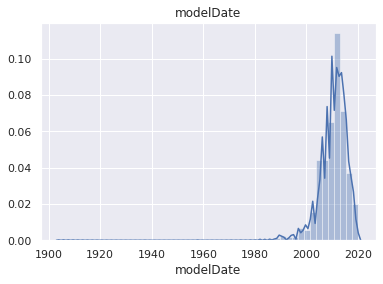

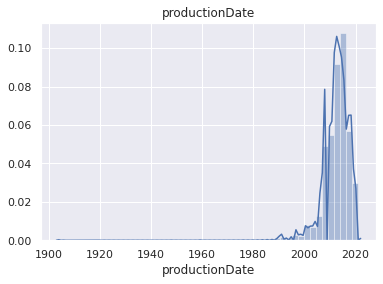

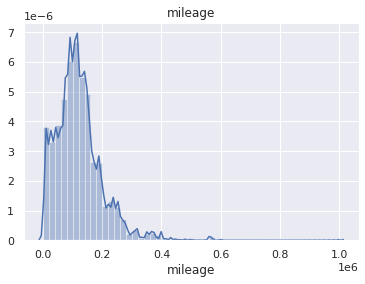

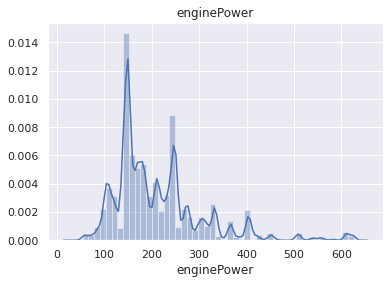

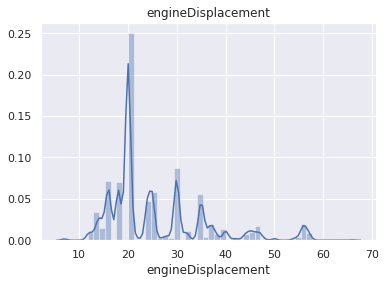

In [31]:
sns.set()
for x in x_num:
    plt.figure()
    sns.distplot(autos[x])
    plt.title(x)
    plt.show()

Попробуем прологарифмировать 'mileage', 'enginePower' и 'engineDisplacement', т.к. виден длинный правый хвост

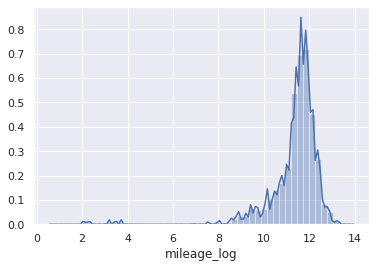

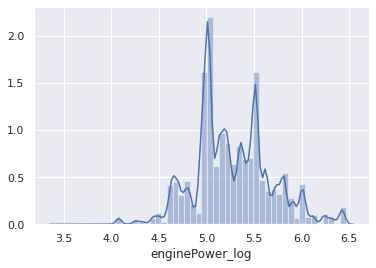

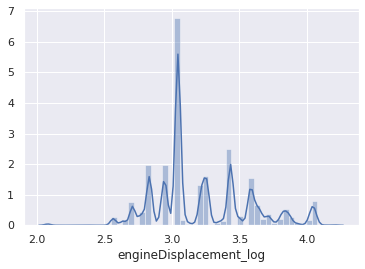

In [32]:
num_to_log = ['mileage', 'enginePower', 'engineDisplacement']
for n in num_to_log:
    autos[n + '_log'] = np.log(autos[n] + 1)
    
    plt.figure()
    sns.distplot(autos[n + '_log'])
    plt.show()

x_num += ['mileage_log', 'enginePower_log', 'engineDisplacement_log']

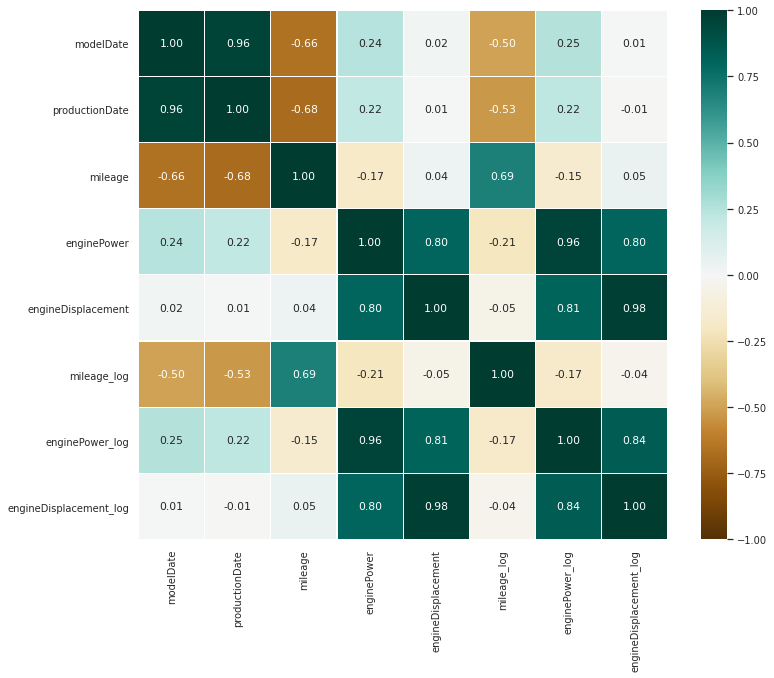

In [33]:
# Посмотрим корреляцию числовых признаков
corr = autos[x_num].corr()

sns.set(font_scale=0.9)
plt.subplots(figsize=(10, 8))
plt.tight_layout()
sns.heatmap(corr, square=True, vmin=-1, vmax=1,
            annot=True, fmt=".2f", linewidths=0.1, cmap="BrBG");

Признаки enginePower и engineDisplacement сильно скоррелированы - сделаем из них один признак. Признаки productionDate и modelDate тоже - можно взять разницу. 'mileage', 'productionDate' - сильная отрицательная корреляция, можно взять удельный пробег. 

### 4.2 Анализ категориальных признаков

In [34]:
for x in x_cat:
    print(x, autos[x].nunique(), '\n', autos[x].value_counts()[:3], '\n')

bodyType 25 
 внедорожник 5 дв.    312787
седан                128257
лифтбек               28419
Name: bodyType, dtype: int64 

brand 12 
 BMW           48872
VOLKSWAGEN    48803
MERCEDES      48571
Name: brand, dtype: int64 

color 16 
 чёрный    179785
белый     101657
серый      72673
Name: color, dtype: int64 

fuelType 5 
 бензин    442264
дизель    102992
гибрид      4664
Name: fuelType, dtype: int64 

model_name 478 
 CR           18643
XC90         17941
OUTLANDER    14735
Name: model_name, dtype: int64 

numberOfDoors 5 
 5    398787
4    137392
2     10164
Name: numberOfDoors, dtype: int64 

vehicleConfiguration 673 
 ALLROAD_5_DOORS AUTOMATIC 2.0    52537
ALLROAD_5_DOORS AUTOMATIC 3.0    41430
ALLROAD_5_DOORS VARIATOR 2.0     27794
Name: vehicleConfiguration, dtype: int64 

vehicleTransmission 4 
 автоматическая      337815
роботизированная     76381
механическая         69725
Name: vehicleTransmission, dtype: int64 

vendor 2 
 EUROPEAN    281641
JAPANESE    268689
Name: v

Очевидно, что model_name и vehicleConfiguration имеют большое количество конфигураций. Посмотрим на остальные признаки более внимательно. 

In [35]:
# Распределение признака по генеральной совокупности и Boxplot целевой переменной price (train)

def get_visual(col):
    fig, axes = plt.subplots(2, 1, figsize = (20,15))
    axes[0].hist(autos[col], bins = 50)
    axes[0].set_title(col)
    
    sns.boxplot(x='price', y=col, data=autos[autos['sample'] == 1], ax=axes[1])
    axes[1].set_title('boxplot for ' + col)
    
    plt.tight_layout()
    plt.show()

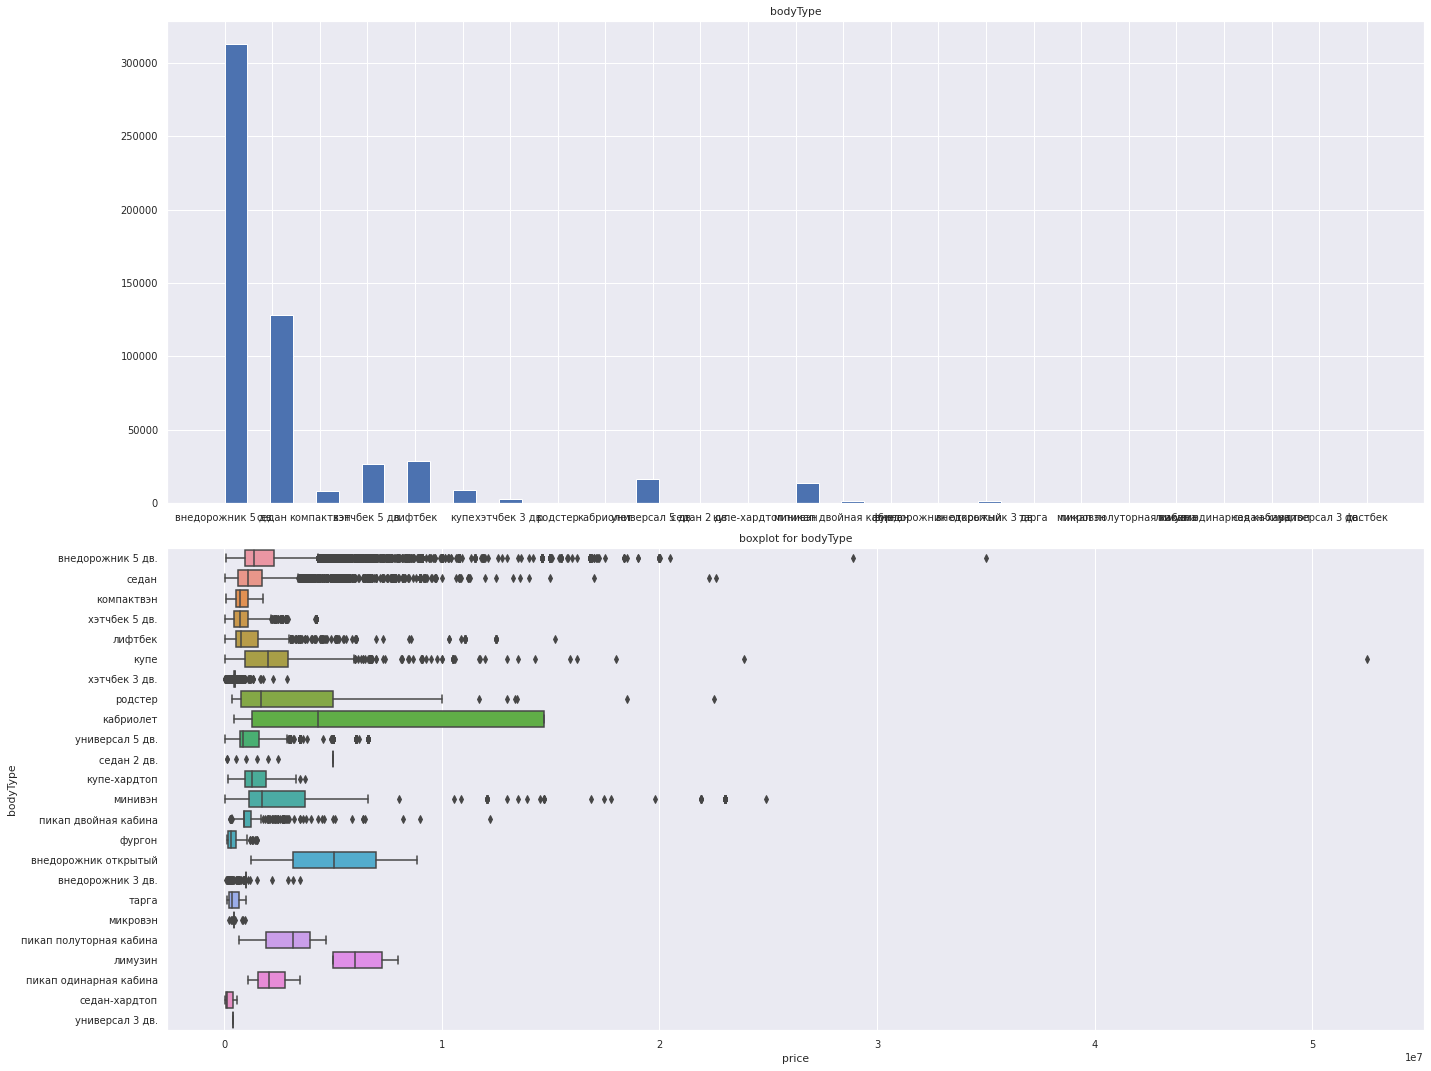

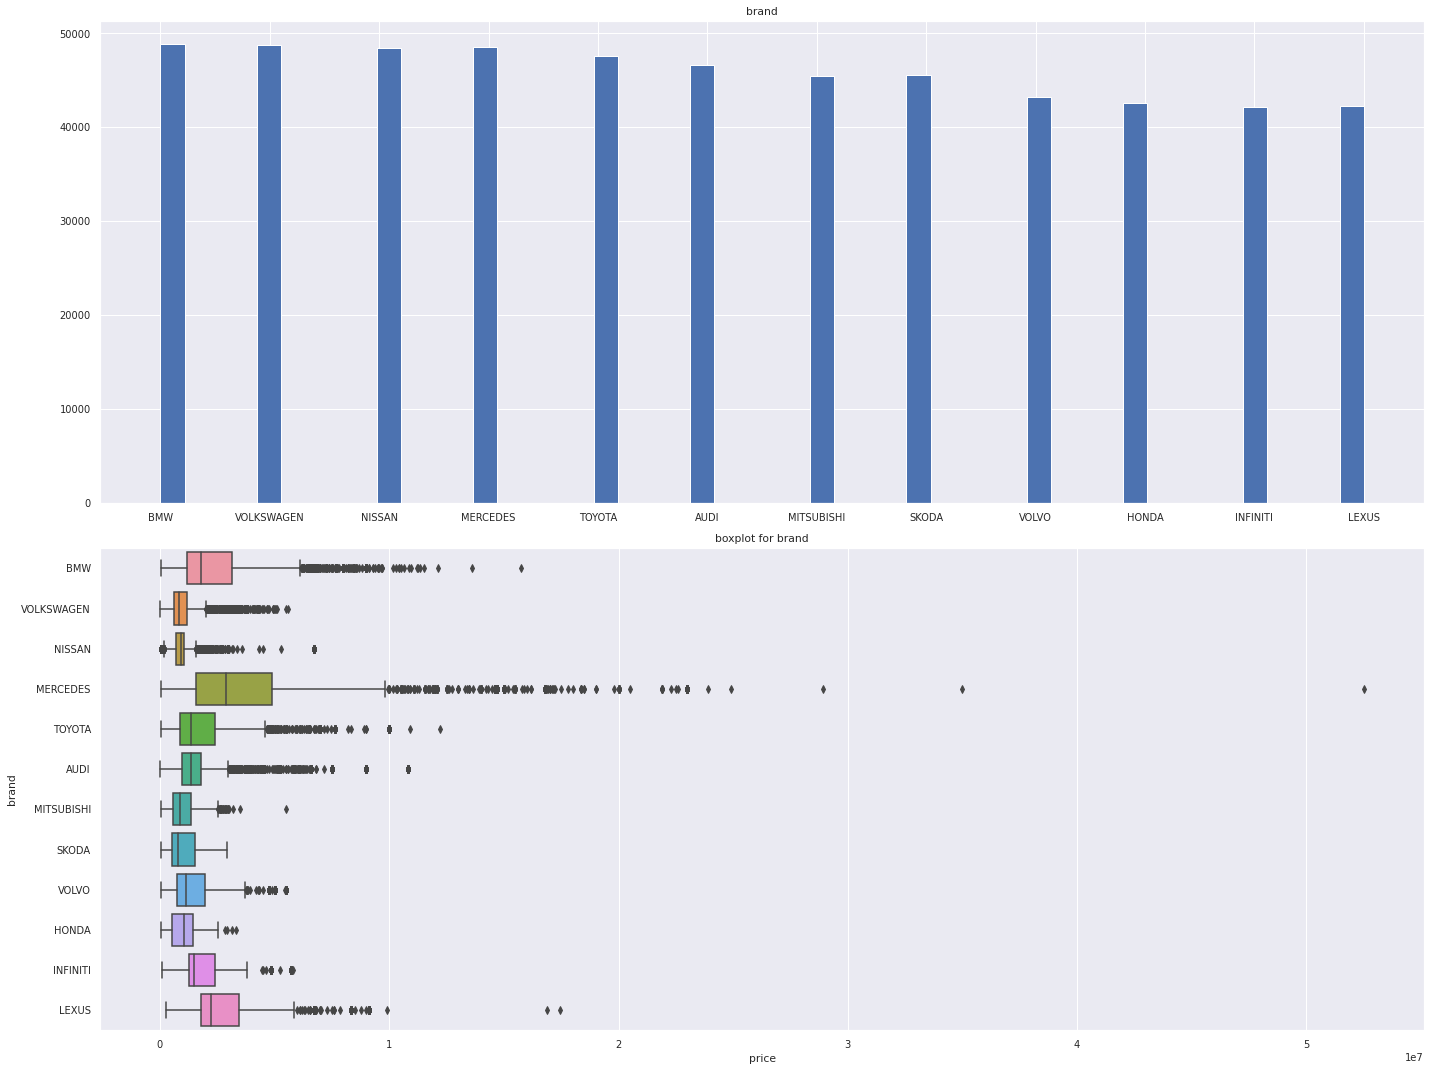

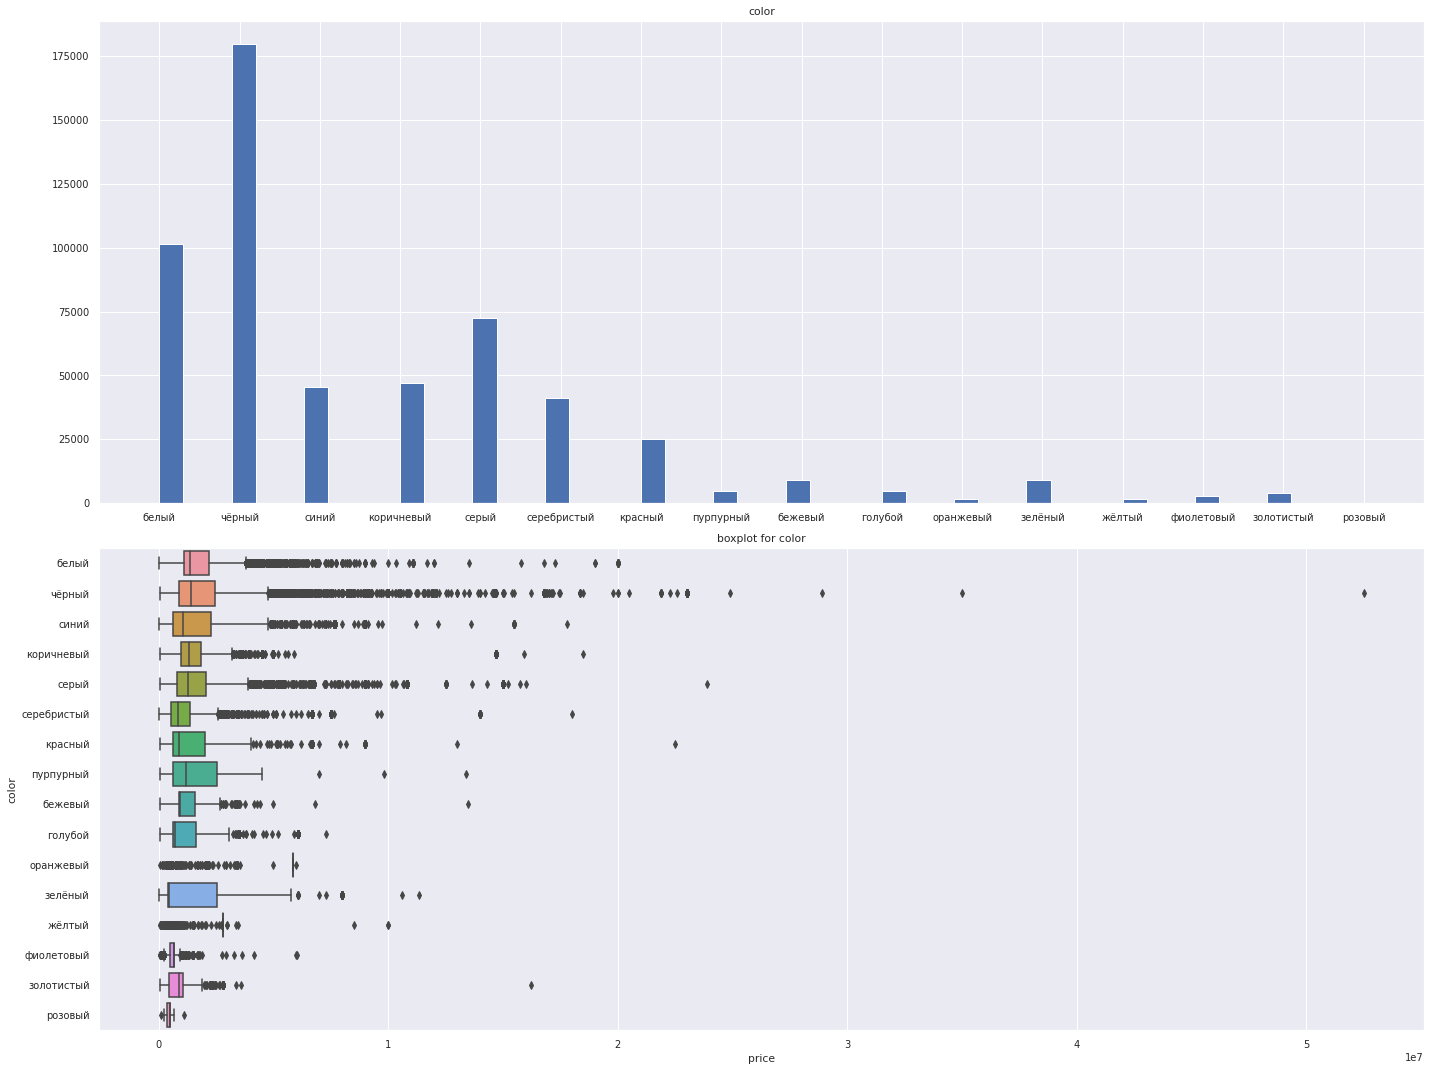

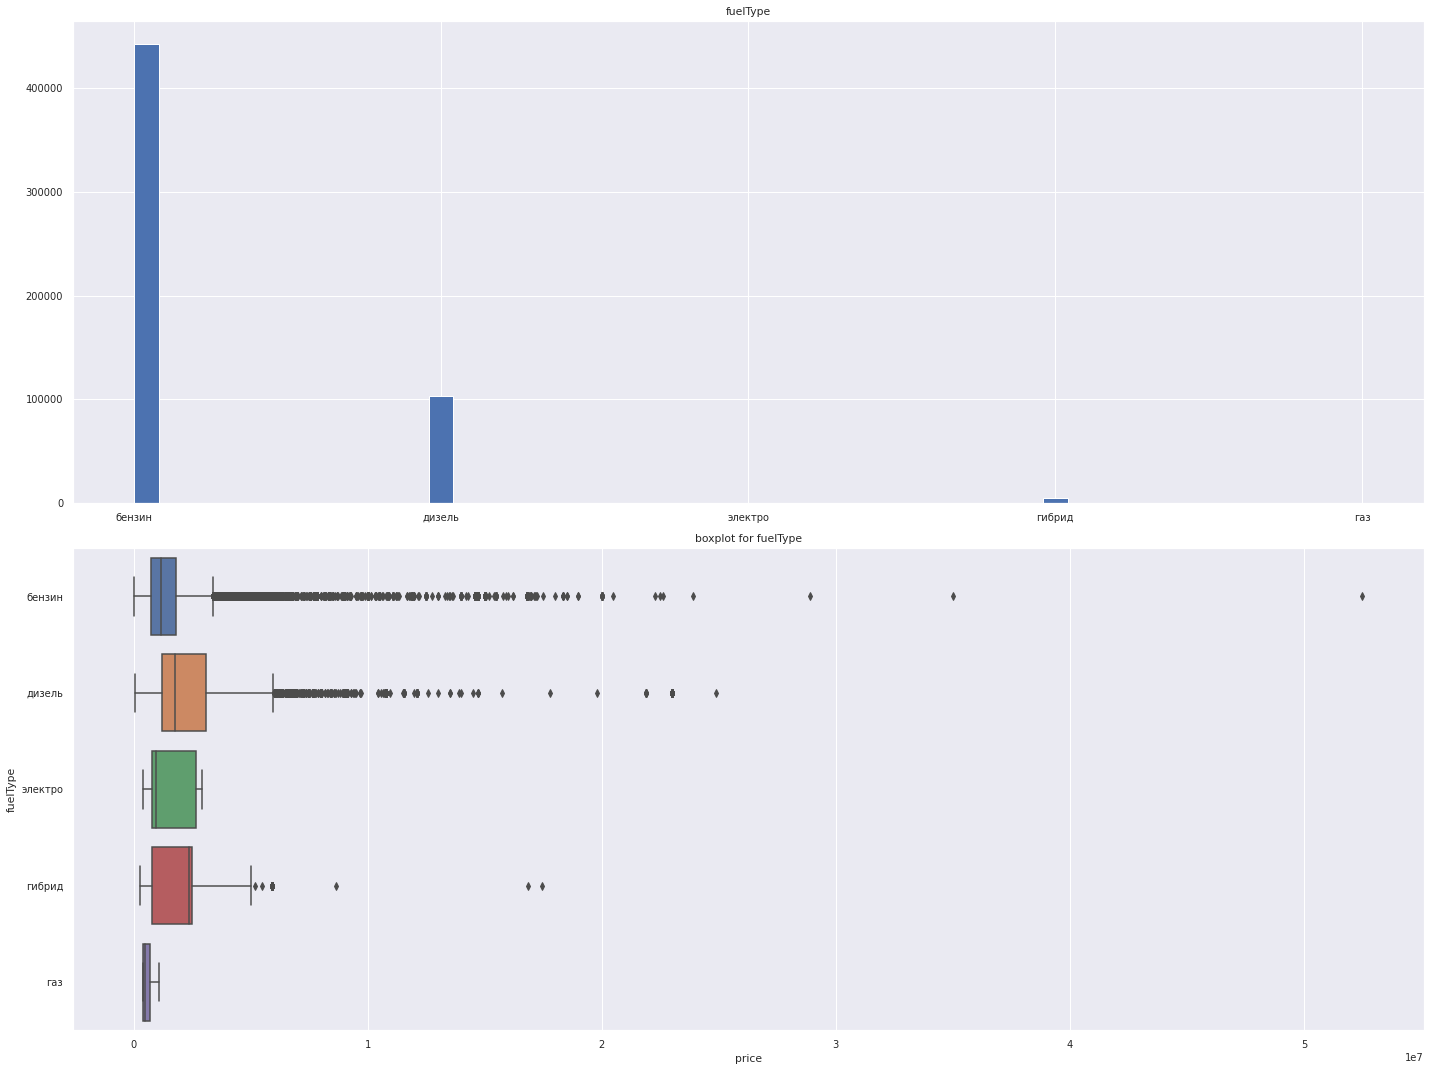

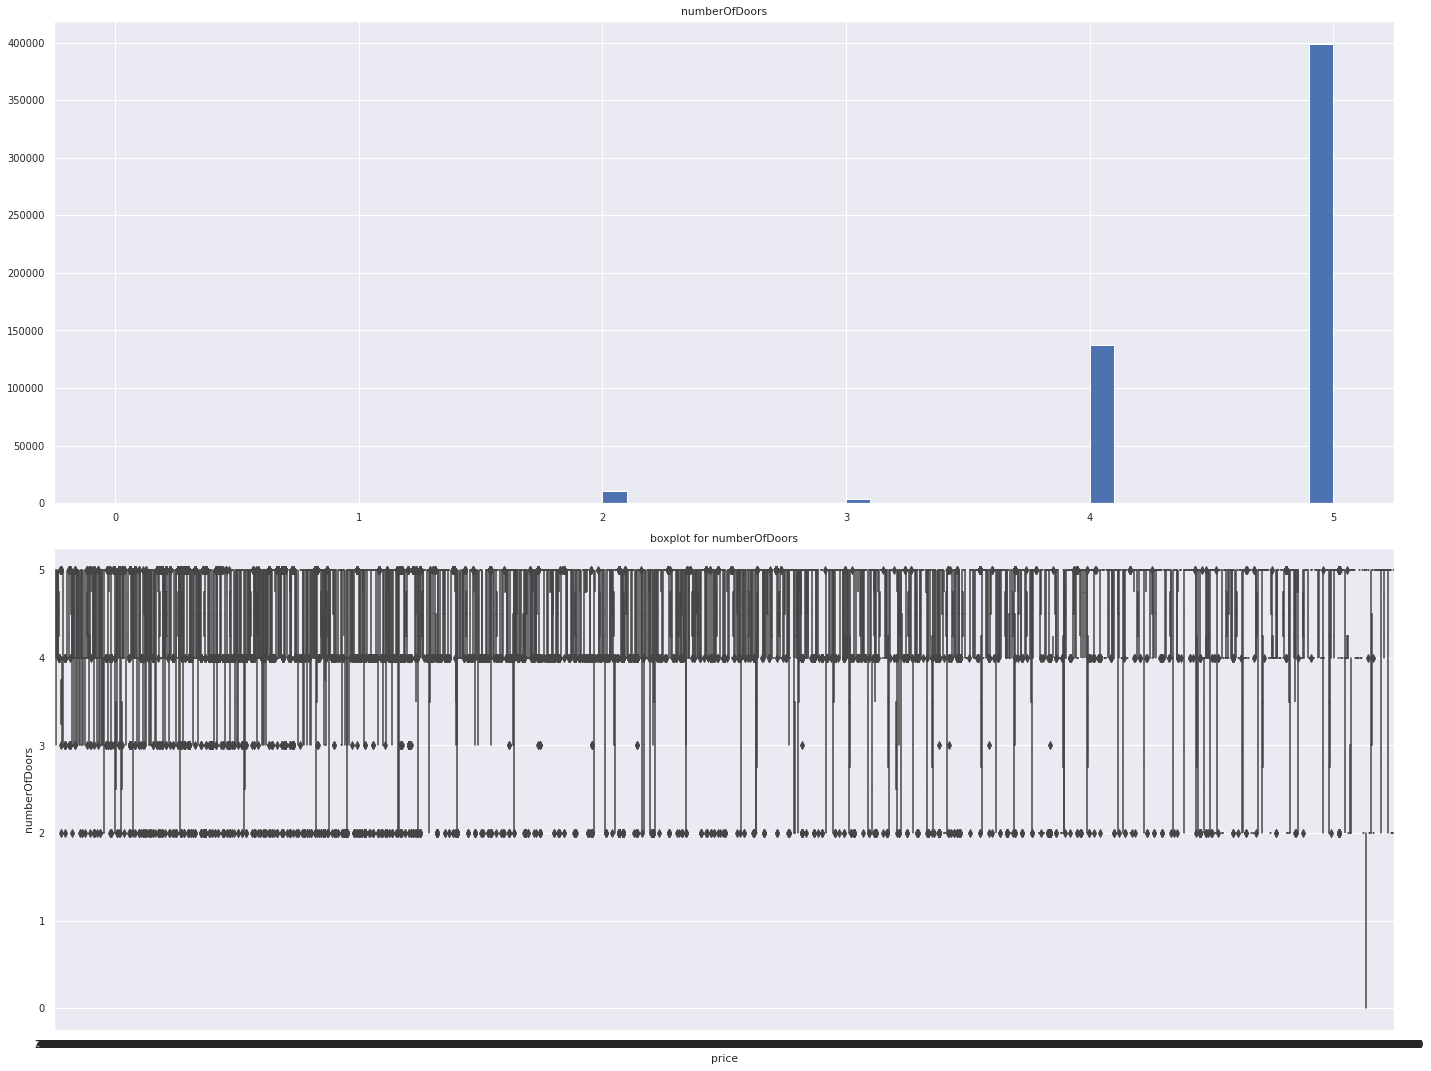

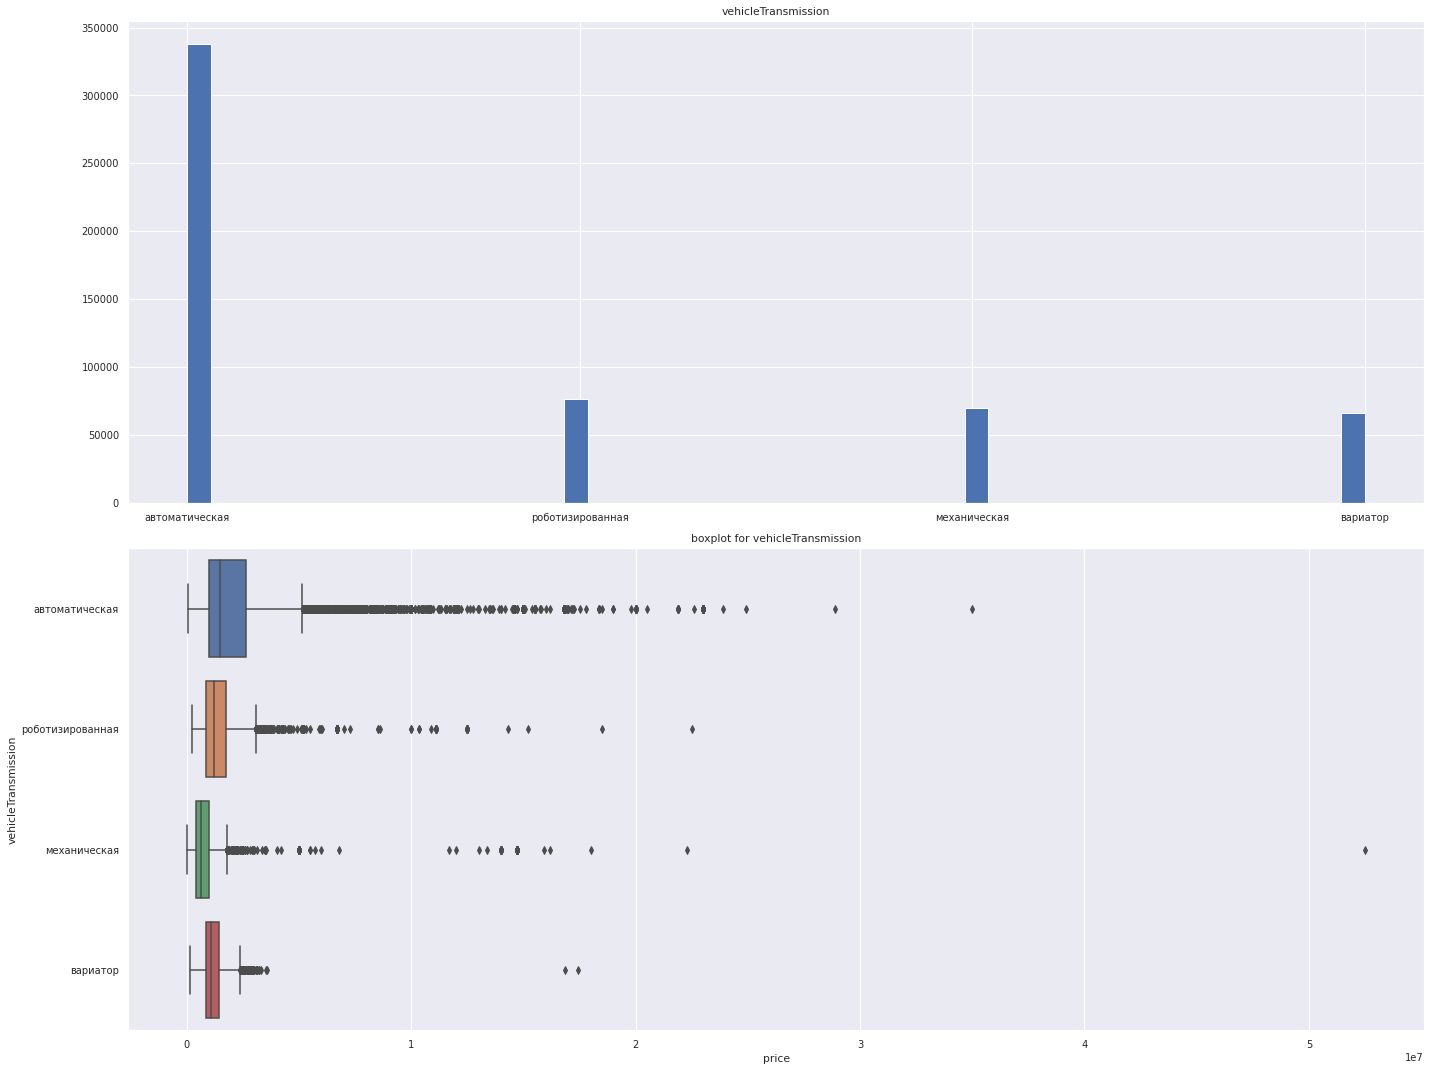

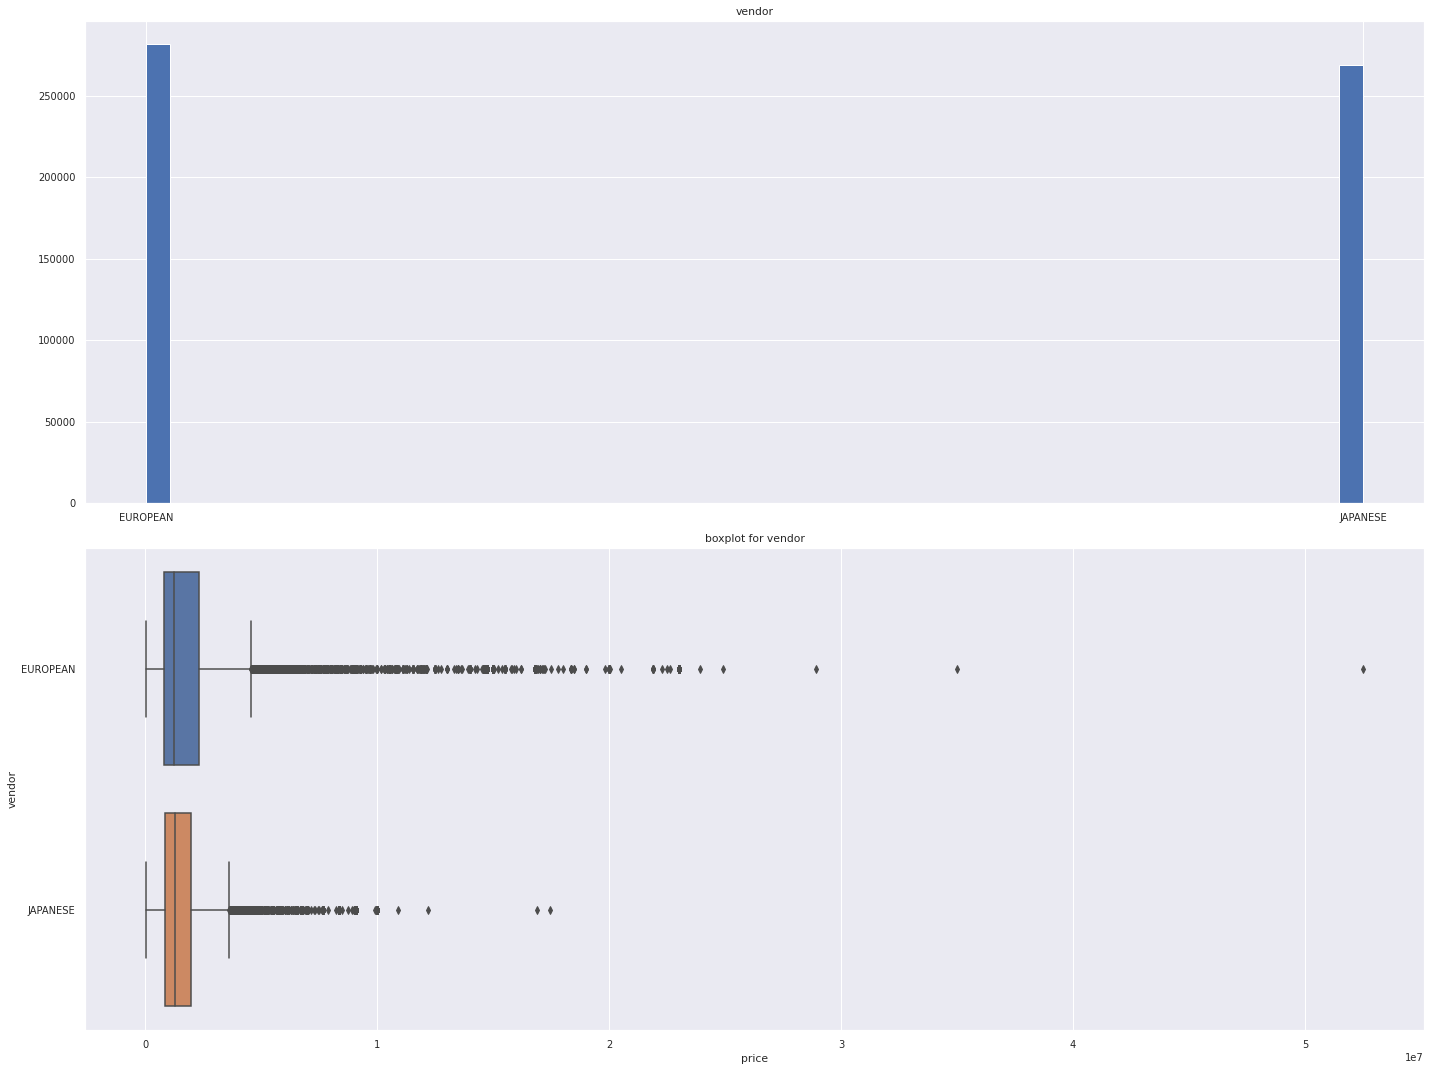

In [36]:
x_cat_box = ['bodyType','brand','color','fuelType',
             'numberOfDoors','vehicleTransmission','vendor']

for i in x_cat_box:
    get_visual(i)

Заметно несколько существенных выбросов по цене в тренировочной выборке в различных разрезах. Самые крупные - MERCEDES, удалять пока не будем.

Проверим люксовость брендов

In [37]:
models = autos.brand.unique()
luxury_cars = {}

for m in models:
    mean_p = round(autos[autos['brand'] == m].price.mean()/1000000, 2)
    med_p = round(autos[autos['brand'] == m].price.median()/1000000, 2)
    luxury_cars[m] = [mean_p, med_p]

print('Сортировка по средней цене:')
display(sorted(luxury_cars.items(), key=lambda x: x[1][0], reverse=True))

print('Сортировка по медиане цены:')
display(sorted(luxury_cars.items(), key=lambda x: x[1][1], reverse=True))

Сортировка по средней цене:


[('MERCEDES', [4.22, 2.87]),
 ('LEXUS', [2.78, 2.23]),
 ('BMW', [2.53, 1.78]),
 ('TOYOTA', [1.89, 1.38]),
 ('INFINITI', [1.84, 1.5]),
 ('VOLVO', [1.61, 1.15]),
 ('AUDI', [1.6, 1.34]),
 ('HONDA', [1.07, 1.04]),
 ('VOLKSWAGEN', [1.06, 0.85]),
 ('NISSAN', [1.06, 0.9]),
 ('SKODA', [0.98, 0.77]),
 ('MITSUBISHI', [0.95, 0.9])]

Сортировка по медиане цены:


[('MERCEDES', [4.22, 2.87]),
 ('LEXUS', [2.78, 2.23]),
 ('BMW', [2.53, 1.78]),
 ('INFINITI', [1.84, 1.5]),
 ('TOYOTA', [1.89, 1.38]),
 ('AUDI', [1.6, 1.34]),
 ('VOLVO', [1.61, 1.15]),
 ('HONDA', [1.07, 1.04]),
 ('NISSAN', [1.06, 0.9]),
 ('MITSUBISHI', [0.95, 0.9]),
 ('VOLKSWAGEN', [1.06, 0.85]),
 ('SKODA', [0.98, 0.77])]

## 5. Feature Engineering

### 5.1 Обработка числовых признаков

In [38]:
# Из предыдущего шага можно выделить топ-5 марок по цене в группу люксовых брендов
autos['luxury'] = autos['brand'].apply(lambda x: 1 \
                                     if x in ['BMW','MERCEDES','LEXUS','INFINITI','TOYOTA'] \
                                     else 0)

In [39]:
# Добавим признак наличия полного привода
autos['allroad'] = autos['vehicleConfiguration'].apply(lambda x: 1 \
                                                       if x.split('_')[0] == 'ALLROAD' \
                                                       else 0)

In [40]:
# Добавим признак устаревания автомобиля на момент производства
autos['model_age'] = autos['productionDate'] - autos['modelDate']
autos['model_age'] = autos['model_age'].apply(lambda x: 0 if x < 0 else x)

# Добавим удельный пробег за год
autos['km_per_year'] = (autos['mileage']/(2021 +1 - autos['productionDate'])).astype('int64') # +1 во избежание деления на ноль

In [41]:
# Добавим с список переменных новые признаки и удалим более не нужные
x_cat.append('luxury')
x_cat.append('allroad')

x_num.append('model_age')
x_num.append('km_per_year')

x_num.remove('modelDate') # есть устаревание модели и год производства
x_num.remove('mileage') # есть логарифмированная величина + удельный пробег
x_num.remove('enginePower') # есть логарифмированная величина
x_num.remove('engineDisplacement') # есть логарифмированная величина

Создадим полиномиальные признаки на основе логарифмированных 'engineDisplacement_log' и 'enginePower_log' и нормируем их

In [42]:
pf = PolynomialFeatures(3)
poly_features = pf.fit_transform(autos[[ 'engineDisplacement_log', 'enginePower_log']])
#poly = pd.DataFrame(poly_features) #после проверки значимости удаляем лишние
poly = pd.DataFrame(poly_features).drop([0, 1, 3, 6], axis = 1)
poly.columns = ['displacement_power_2', 'displacement_power_4', 'displacement_power_5', 
                'displacement_power_7', 'displacement_power_8', 'displacement_power_9']

for column in list(poly.columns):
    max_column = poly[column].max()    
    poly[column] = poly[column].apply(lambda x: round(x/max_column, 3))
    
autos = pd.concat([autos, poly], axis=1) # конкатенировать однократно

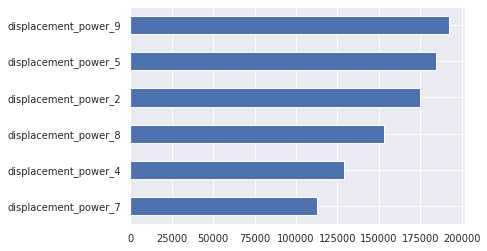

In [43]:
x_num_pf1 = list(poly.columns)

# Проверка значимости полиномиальных признаков
check_X = autos[autos['sample'] == 1][x_num_pf1]
check_Y = autos[autos['sample'] == 1]['price']

imp_num = Series(f_regression(check_X, check_Y)[0], index = x_num_pf1)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

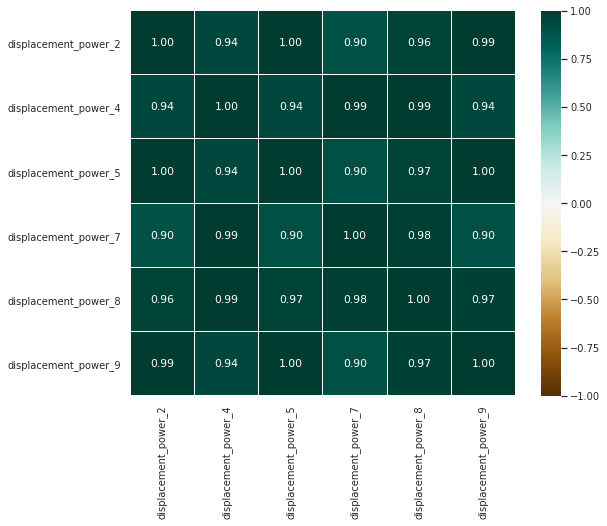

In [44]:
corr = autos[x_num_pf1].corr()

sns.set(font_scale=0.9)
plt.subplots(figsize=(8, 6))
plt.tight_layout()
sns.heatmap(corr, square=True, vmin=-1, vmax=1,
            annot=True, fmt=".2f", linewidths=0.1, cmap="BrBG");

Признаки между собой очень сильно скоррелированы. Поэтому оставим только самый значимый №9

Повторим для 'productionDate' и 'enginePower_log'

In [45]:
poly_features = pf.fit_transform(autos[['productionDate', 'enginePower_log']])
poly = pd.DataFrame(poly_features).drop([0, 1], axis = 1) #после проверки значимости удаляем незначимые столбцы
poly.columns = ['date_power_2', 'date_power_3','date_power_4', 'date_power_5', 
                'date_power_6', 'date_power_7', 'date_power_8', 'date_power_9']

for column in list(poly.columns):
    max_column = poly[column].max()    
    poly[column] = poly[column].apply(lambda x: round(x/max_column, 3))
    
autos = pd.concat([autos, poly], axis=1)

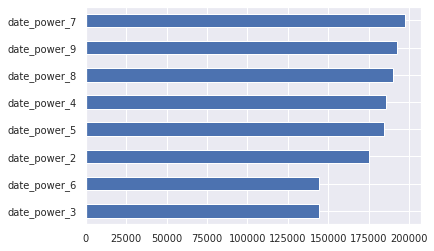

In [46]:
x_num_pf2 = list(poly.columns)

# Проверка значимости полиномиальных признаков
check_X = autos[autos['sample'] == 1][x_num_pf2]
check_Y = autos[autos['sample'] == 1]['price']

imp_num = Series(f_regression(check_X, check_Y)[0], index = x_num_pf2)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

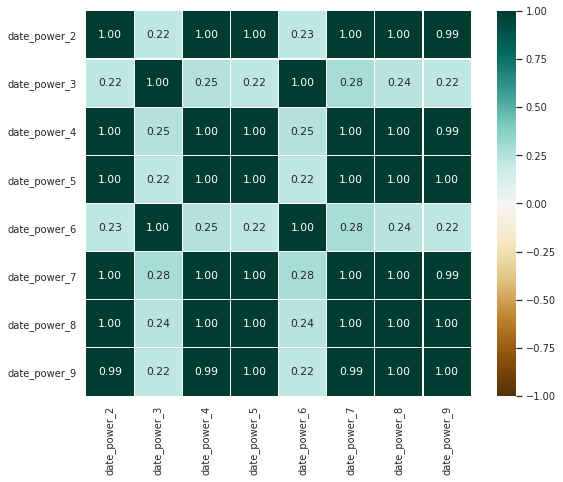

In [47]:
corr = autos[x_num_pf2].corr()

sns.set(font_scale=0.9)
plt.subplots(figsize=(8, 6))
plt.tight_layout()
sns.heatmap(corr, square=True, vmin=-1, vmax=1,
            annot=True, fmt=".2f", linewidths=0.1, cmap="BrBG");

Из полученных признаков оставим лучшие некоррелирующие между собой №7 и №6

In [48]:
x_check = ['productionDate', 'mileage_log', 'engineDisplacement_log', 'model_age',
           'km_per_year', 'displacement_power_9', 'date_power_6', 'date_power_7']

### 5.2 Label Encoding

In [49]:
# Кодируем категориальные признаки
label_encoder = LabelEncoder()
for col in x_cat:
    autos[col] = label_encoder.fit_transform(autos[col])

In [50]:
x_check += x_cat

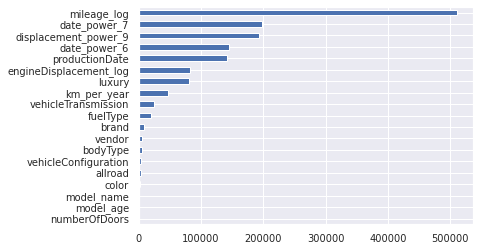

In [51]:
# Проверка значимости 
check_X = autos[autos['sample'] == 1][x_check]
check_Y = autos[autos['sample'] == 1]['price']

imp_num = Series(f_regression(check_X, check_Y)[0], index = x_check)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

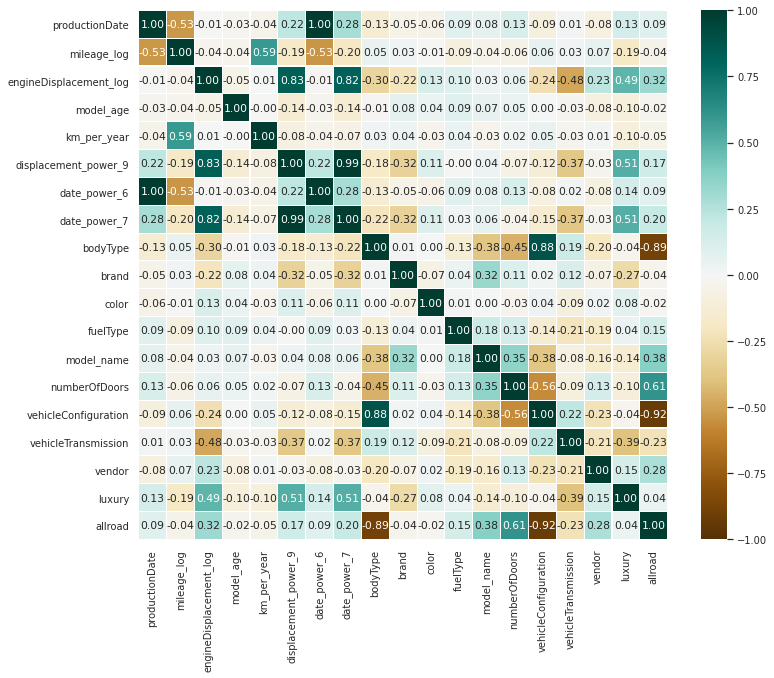

In [52]:
# Проверим совокупную корреляцию признаков

corr = autos[x_check].corr()

sns.set(font_scale=0.9)
plt.subplots(figsize=(10, 8))
plt.tight_layout()
sns.heatmap(corr, square=True, vmin=-1, vmax=1,
            annot=True, fmt=".2f", linewidths=0.1, cmap="BrBG");

## 6. Построение модели

In [53]:
x_check += ['sample']
#x_check

In [54]:
X_train_test = autos[x_check].copy()


# Разделяем обратно на train и test
train = X_train_test.query('sample == 1').drop(['sample'], axis=1)
test = X_train_test.query('sample == 0').drop(['sample'], axis=1)

y = autos.copy().query('sample == 1')['price']

# Делим train для обучения и проверки моделей
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [55]:
print(y.shape)
print(X_train.shape)
print(X_test.shape)
print(test.shape)

#print(X_train.shape[0] + X_test.shape[0] + test.shape[0])

(515644,)
(412515, 19)
(103129, 19)
(34686, 19)


In [56]:
# Логарифмироварие целевой переменной улучшает качество модели
y_train = y_train.apply(lambda x: math.log(x))
y_test = y_test.apply(lambda x: math.log(x))

y = y.apply(lambda x: math.log(x)).values

X = train.values
X_pred = test.values

In [57]:
# Функция для расчёта метрики MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [58]:
X_pred.shape

(34686, 19)

### 6.1 CatBoost

In [59]:
iters = 20000
LR = 0.15

cbr = CatBoostRegressor(iterations = iters,
                          learning_rate = LR,
                          depth = 8,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE']
                         )

cbr.fit(X_train, y_train,
        eval_set=(X_test, y_test),
        verbose_eval=500,
        use_best_model=True,
        plot=True
        )


y_predict_1 = cbr.predict(X_test)

# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_predict_1))*100:0.5f}%")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0369171	test: 0.0369102	best: 0.0369102 (0)	total: 130ms	remaining: 43m 17s
500:	learn: 0.0008752	test: 0.0009803	best: 0.0009803 (499)	total: 30.5s	remaining: 19m 45s
1000:	learn: 0.0005685	test: 0.0007322	best: 0.0007321 (999)	total: 1m 1s	remaining: 19m 24s
1500:	learn: 0.0004399	test: 0.0006451	best: 0.0006449 (1499)	total: 1m 33s	remaining: 19m 8s
2000:	learn: 0.0003692	test: 0.0006060	best: 0.0006060 (2000)	total: 2m 7s	remaining: 19m 8s
2500:	learn: 0.0003202	test: 0.0005825	best: 0.0005822 (2496)	total: 2m 42s	remaining: 18m 54s
3000:	learn: 0.0002849	test: 0.0005680	best: 0.0005680 (3000)	total: 3m 17s	remaining: 18m 41s
3500:	learn: 0.0002555	test: 0.0005573	best: 0.0005573 (3499)	total: 3m 53s	remaining: 18m 21s
4000:	learn: 0.0002323	test: 0.0005500	best: 0.0005500 (3997)	total: 4m 31s	remaining: 18m 3s
4500:	learn: 0.0002121	test: 0.0005441	best: 0.0005441 (4500)	total: 5m 9s	remaining: 17m 45s
5000:	learn: 0.0001946	test: 0.0005391	best: 0.0005391 (5000)	total

### 6.2 Random Forest

In [64]:
rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=14)

In [65]:
y_predict_2 = rf.predict(X_test)
print(f"Test MAPE: {mape(y_test, y_predict_2)*100:0.5f}%")

Test MAPE: 0.05650%


Результат  хуже

### 6.3 Bagging

In [ ]:
max_feat = int(X_train.shape[1] / 3)
max_feat

In [ ]:
tree = DecisionTreeRegressor(max_features=max_feat, max_depth=130)
bagging_trees = BaggingRegressor(tree)
bagging_trees.fit(X_train, y_train)

y_predict_3 = bagging_trees.predict(X_test)
print(f"BaggingRegressor(DecisionTrees) Test MAPE: {mape(y_test, y_predict_3)*100:0.5f}%")

По качеству не лучше предыдущих моделей

### 6.4 Gradient Boosting

In [ ]:
gb = GradientBoostingRegressor(max_depth=7, n_estimators=1500, 
                               learning_rate=0.1, random_state=RANDOM_SEED)
gb.fit(X_train, y_train)

y_predict_4 = gb.predict(X_test)
print(f"GradientBoostingRegressor Test MAPE: {mape(y_test, y_predict_4)*100:0.5f}%")

Значение метрики чуть хуже

## 7. Submission

In [62]:
sample_submission = pd.read_csv('../input/sf-dst-car-price-prediction/sample_submission.csv')

In [63]:
# CatBoost
sample_sub = sample_submission.copy()
y_pred_1_sub = np.exp(cbr.predict(X_pred)).round(0).astype('int64')
sample_sub['price'] = y_pred_1_sub
sample_sub.to_csv('submission_1.csv', index=False)
display(sample_sub.head(3))
sample_sub.info()

,sell_id,price
0,1100575026,683029
1,1100549428,943790
2,1100658222,880768


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sell_id  34686 non-null  int64
 1   price    34686 non-null  int64
dtypes: int64(2)
memory usage: 542.1 KB


In [66]:
# Random Forest
sample_sub = sample_submission.copy()
y_pred_2_sub = np.exp(rf.predict(X_pred)).round(0).astype('int64')
sample_sub['price'] = y_pred_2_sub
sample_sub.to_csv('submission_2.csv', index=False)
display(sample_sub.head(3))
sample_sub.info()

,sell_id,price
0,1100575026,640823
1,1100549428,938012
2,1100658222,866952


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sell_id  34686 non-null  int64
 1   price    34686 non-null  int64
dtypes: int64(2)
memory usage: 542.1 KB


In [ ]:
# Bagging Trees
sample_sub = sample_submission.copy()
y_pred_3_sub = np.exp(bagging_trees.predict(X_pred)).round(0).astype('int64')
sample_sub['price'] = y_pred_3_sub
sample_sub.to_csv('submission_3.csv', index=False)
display(sample_sub.head(3))
sample_sub.info()

In [ ]:
# Gradient Boosting
sample_sub = sample_submission.copy()
y_pred_4_sub = np.exp(gb.predict(X_pred)).round(0).astype('int64')
sample_sub['price'] = y_pred_4_sub
sample_sub.to_csv('submission_4.csv', index=False)
display(sample_sub.head(3))
sample_sub.info()

## Итог

* Получена информация с сайта auto.ru о >515 тыс. объявлений
* Признаки унифицированы с признаками из теста
* Проведены анализ признаков, оценка их важности и скоррелированности
* Созданы новые признаки и отобран набор для работы с алгоритмами
* Протестировано 4 типа алгоритмов с регрессорами
* Лучшую оценку MAPE показал Gradient Boosting